In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import joblib
import time
from datetime import timedelta

import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm

In [19]:
def odchylenie_reszt(real, pred, m):
    return (sum((real-pred)**2)*(1/(len(real)-m-1)))**0.5


df = pd.read_parquet('data/cars_clean_features.parquet')
df.info(verbose=False)

dataset_constraint = -1
n_sim = 40

x = df.iloc[:dataset_constraint,1:]
y = df.iloc[:dataset_constraint,0] 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.05,stratify=x['marka_var'], random_state=34)


# rozwazane modele
lm = LinearRegression()
ridge = Ridge(alpha=0.3, solver='svd')
tree = DecisionTreeRegressor(max_depth=23, min_samples_leaf=15, min_samples_split=28, max_features=0.8)
rf = RandomForestRegressor(max_depth=18, min_samples_split=4, n_estimators=170, random_state=34)

x_gen = df.iloc[:dataset_constraint,1:]
y_gen = df.iloc[:dataset_constraint,0] 

x_gen['x0x2'] = x_gen.iloc[:,0] * x_gen.iloc[:,2]

x_gen_train, x_gen_test, y_gen_train, y_gen_test = train_test_split(x_gen, y_gen, test_size=0.05,stratify=x_gen['marka_var'], random_state=34)


# model do generowania danych
model = LinearRegression()
model.fit(x_gen,y_gen)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 75169 entries, 0 to 75168
Columns: 796 entries, cena to pojemnosc_bin_3
dtypes: float64(19), int64(10), int8(767)
memory usage: 72.2 MB


LinearRegression()

In [20]:
def simulation3(iter=1, model=model):
    df_results = pd.DataFrame()

    std_reszt = odchylenie_reszt(y_gen_train, model.predict(x_gen_train), x_gen_train.shape[1])
    
    # shifted gamma distribution
    y_mu = 2500
    y_sig2 = std_reszt**2/100
    y_as = 1.2
    k = 4/(y_as**2)
    Teta = (y_sig2/k)**0.5
    EX = k*Teta
    e_train = pd.Series(np.random.gamma(shape=k, scale=Teta, size=len(x_gen_train))-EX+y_mu)
    e_test = pd.Series(np.random.gamma(shape=k, scale=Teta, size=len(x_gen_test))-EX+y_mu)

    model_pred = np.array((x_gen_train.iloc[:,:-1] * model.coef_[:-1] ).sum(axis=1) + x_gen_train.iloc[:,-1] * model.coef_[-1]*3 + model.intercept_ )
    model_pred_test = np.array((x_gen_test.iloc[:,:-1] * model.coef_[:-1] ).sum(axis=1) + x_gen_test.iloc[:,-1] * model.coef_[-1]*3 + model.intercept_ )
    rand_y_train = pd.Series(model_pred) + e_train 
    rand_y_test = pd.Series(model_pred_test) + e_test

    lm.fit(x_train, rand_y_train)
    ridge.fit(x_train, rand_y_train)
    tree.fit(x_train, rand_y_train)
    rf.fit(x_train, rand_y_train)
    
    df_results['rand_y'] = rand_y_test
    df_results['lm'] = lm.predict(x_test)
    df_results['ridge'] = ridge.predict(x_test)
    df_results['tree'] = tree.predict(x_test)
    df_results['rf'] = rf.predict(x_test)
    df_results['observation'] = list(range(0,len(rand_y_test)))
    df_results['iteration'] = iter
    
    return df_results



In [21]:
results_nonlinear = joblib.Parallel(n_jobs = 7, verbose = 13)(joblib.delayed(simulation3)(i) for i in range(n_sim))

full_results = pd.DataFrame()
for dfs in results_nonlinear:
    full_results = pd.concat([full_results, dfs])

full_results['lm_error'] = full_results['lm'] - full_results['rand_y']
full_results['ridge_error'] = full_results['ridge']- full_results['rand_y']
full_results['tree_error'] = full_results['tree']- full_results['rand_y']
full_results['rf_error'] = full_results['rf']- full_results['rand_y']

print('saving files...')
file_name = 'sim_results/sim3_results2.parquet'
full_results.to_parquet(file_name)
#full_results.to_csv(file_name)
print('finished')

print(abs(full_results.groupby('observation').mean()).mean())


[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:  9.2min
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:  9.2min
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:  9.2min
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:  9.3min
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:  9.3min
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:  9.3min
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:  9.3min
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed: 18.2min
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed: 18.2min
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed: 18.2min
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed: 18.2min
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed: 18.2min
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed: 18.3min
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed: 18.3min
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed: 27.0min
[Parallel(

saving files...
finished
rand_y         70761.489617
lm             72053.086318
ridge          72071.966619
tree           70292.640354
rf             70254.706924
iteration         19.500000
lm_error       16991.200727
ridge_error    17002.754104
tree_error      7184.010429
rf_error        5894.087284
dtype: float64


In [4]:
#df = full_results
df = pd.read_parquet('sim_results/sim3_results.parquet')

df['lm_error2'] = df['lm_error']**2
df['ridge_error2'] = df['ridge_error']**2
df['tree_error2'] = df['tree_error']**2
df['rf_error2'] = df['rf_error']**2

df_agg = df.groupby('observation').mean().reset_index()
df_agg.head(3)

# BIAS
df_agg['lm_bias'] = df_agg['lm'] - df_agg['rand_y']
df_agg['lm_bias_relative'] = 100*df_agg['lm_bias']/df_agg['rand_y']

df_agg['ridge_bias'] = df_agg['ridge'] - df_agg['rand_y']
df_agg['ridge_bias_relative'] = 100*df_agg['ridge_bias']/df_agg['rand_y']

df_agg['tree_bias'] = df_agg['tree'] - df_agg['rand_y']
df_agg['tree_bias_relative'] = 100*df_agg['tree_bias']/df_agg['rand_y']

df_agg['rf_bias'] = df_agg['rf'] - df_agg['rand_y']
df_agg['rf_bias_relative'] = 100*df_agg['rf_bias']/df_agg['rand_y']

# RMSE
df_agg['lm_rmse'] = df_agg['lm_error2']**0.5
df_agg['lm_rmse_rel'] = 100*df_agg['lm_rmse']/df_agg['rand_y']

df_agg['ridge_rmse'] = df_agg['ridge_error2']**0.5
df_agg['ridge_rmse_rel'] = 100*df_agg['ridge_rmse']/df_agg['rand_y']

df_agg['tree_rmse'] = df_agg['tree_error2']**0.5
df_agg['tree_rmse_rel'] = 100*df_agg['tree_rmse']/df_agg['rand_y']

df_agg['rf_rmse'] = df_agg['rf_error2']**0.5
df_agg['rf_rmse_rel'] = 100*df_agg['rf_rmse']/df_agg['rand_y']

# sim1
df_agg.iloc[:,15:].describe().iloc[1,:]

lm_bias                 -505.249913
lm_bias_relative         125.851033
ridge_bias              -513.687652
ridge_bias_relative      128.107649
tree_bias                -79.827296
tree_bias_relative        22.501806
rf_bias                   42.574640
rf_bias_relative           4.458283
lm_rmse                17343.859016
lm_rmse_rel              116.343467
ridge_rmse             17354.197898
ridge_rmse_rel           118.467789
tree_rmse              11629.447481
tree_rmse_rel             37.886586
rf_rmse                 6636.059351
rf_rmse_rel               24.163678
Name: mean, dtype: float64

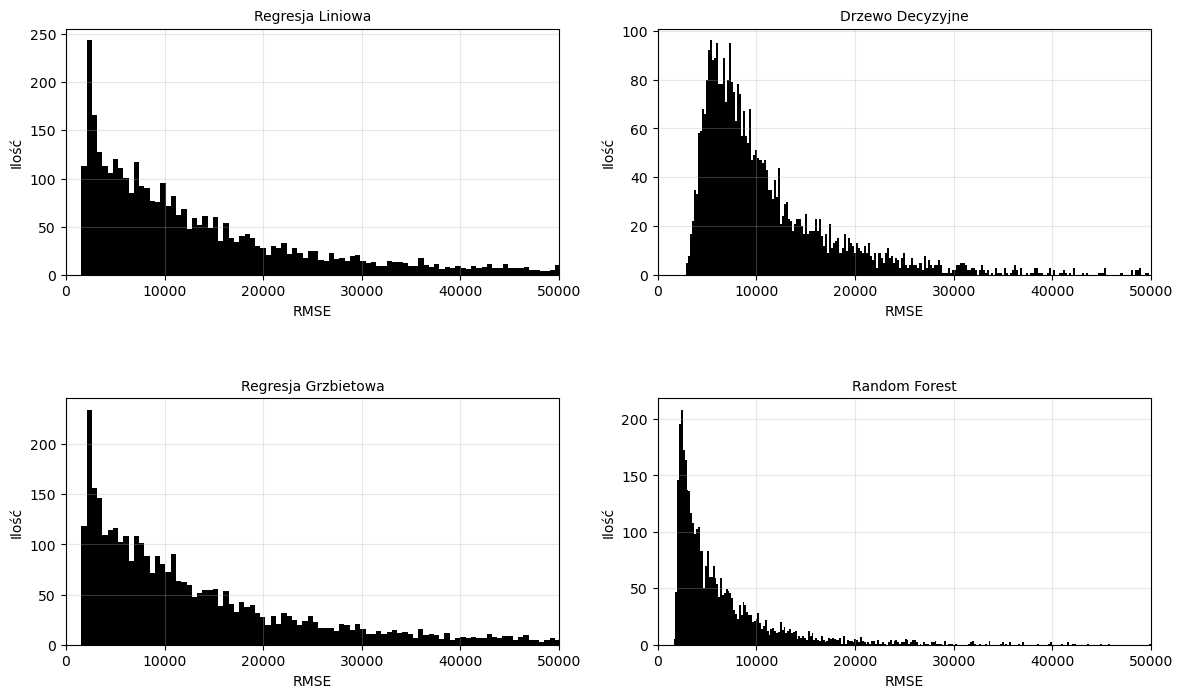

In [6]:
fig, axs = plt.subplots(2,2, figsize=(14,8))

cols = ['lm_rmse', 'ridge_rmse', 'tree_rmse', 'rf_rmse']
titles = ['Regresja Liniowa', 'Regresja Grzbietowa', 'Drzewo Decyzyjne', 'Random Forest']

for row, col in enumerate(cols[:2]):

    axs[row, 0].hist(df_agg[col], bins=500, color='black')
    axs[row, 0].grid(alpha=0.3)
    axs[row, 0].set_title(titles[row], fontsize=10)

    axs[row, 0].set_ylabel('Ilość')
    axs[row,0].set_xlabel('RMSE')
    #axs[row,0].set_xlim([15000, 40000])
    axs[row,0].set_xlim([0000, 50000])

for row, col in enumerate(cols[2:]):

    axs[row, 1].hist(df_agg[col], bins=500, color='black')
    axs[row, 1].grid(alpha=0.3)
    axs[row, 1].set_title(titles[row+2], fontsize=10)
    axs[row, 1].set_ylabel('Ilość')
    axs[row,1].set_xlabel('RMSE')
    #axs[row,1].set_xlim([15000, 40000])
    axs[row,1].set_xlim([0, 50000])

plt.subplots_adjust(hspace=0.5)
plt.show()


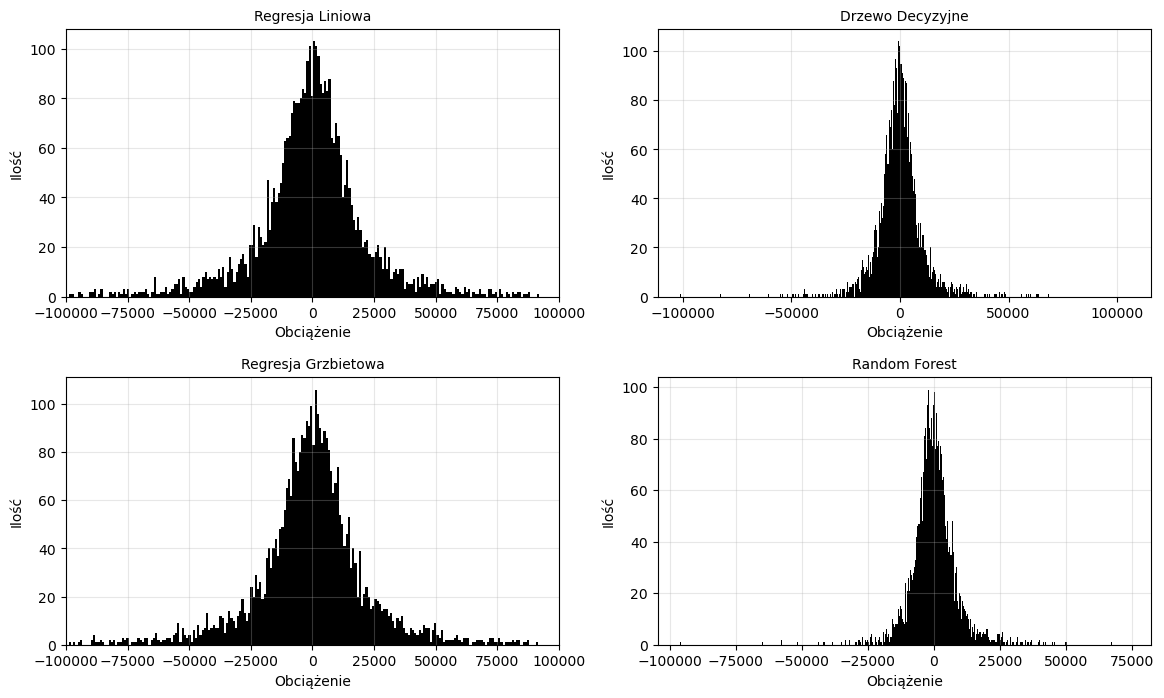

In [13]:
fig, axs = plt.subplots(2,2, figsize=(14,8))

cols = ['lm_bias', 'ridge_bias', 'tree_bias', 'rf_bias']
titles = ['Regresja Liniowa', 'Regresja Grzbietowa', 'Drzewo Decyzyjne', 'Random Forest']

for row, col in enumerate(cols[:2]):

    axs[row, 0].hist(df_agg[col], bins=500, color='black')
    axs[row, 0].grid(alpha=0.3)
    axs[row, 0].set_title(titles[row], fontsize=10)

    axs[row, 0].set_ylabel('Ilość')
    axs[row,0].set_xlabel('Obciążenie')
    #axs[row,0].set_xlim([15000, 40000])
    axs[row,0].set_xlim([-100000, 100000])

for row, col in enumerate(cols[2:]):

    axs[row, 1].hist(df_agg[col], bins=500, color='black')
    axs[row, 1].grid(alpha=0.3)
    axs[row, 1].set_title(titles[row+2], fontsize=10)
    axs[row, 1].set_ylabel('Ilość')
    axs[row,1].set_xlabel('Obciążenie')
    #axs[row,1].set_xlim([15000, 40000])
    axs[row,0].set_xlim([-100000, 100000])

plt.subplots_adjust(hspace=0.3)
plt.show()
